# RoBERTa base model - Classification

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset as HFDataset
from sklearn.metrics import accuracy_score, classification_report

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
TrainServices = pd.read_hdf('RandomSplittedByCatagories9.h5', key='Train')
TestServices = pd.read_hdf('RandomSplittedByCatagories9.h5', key='Test')

# Combine for label encoding
AllData = pd.concat([TrainServices, TestServices])

In [2]:
label_encoder = LabelEncoder()
AllData['Service Classification'] = label_encoder.fit_transform(AllData['Service Classification'])
TrainServices['Service Classification'] = label_encoder.transform(TrainServices['Service Classification'])
TestServices['Service Classification'] = label_encoder.transform(TestServices['Service Classification'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define dataset class
class ServiceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {"input_ids": encoding['input_ids'].squeeze().to(device), "attention_mask": encoding['attention_mask'].squeeze().to(device), "labels": torch.tensor(label, dtype=torch.long).to(device)}

In [4]:
# Tokenizer
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Create datasets
train_dataset = ServiceDataset(list(TrainServices['Service Desciption']), list(TrainServices['Service Classification']), tokenizer)
test_dataset = ServiceDataset(list(TestServices['Service Desciption']), list(TestServices['Service Classification']), tokenizer)


# Load model
num_labels = len(label_encoder.classes_)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)  # Move model to GPU if available
print(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


In [5]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [6]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True
)

# Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)
# Train the model
trainer.train()

C:\Users\91956\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\91956\AppData\Local\Temp\ipykernel_10268\2245322900.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.206600,1.458122
2,0.999800,1.206268
3,0.872400,1.169698


TrainOutput(global_step=3048, training_loss=1.3373986725106326, metrics={'train_runtime': 1405.6022, 'train_samples_per_second': 17.337, 'train_steps_per_second': 2.168, 'total_flos': 1603629149566464.0, 'train_loss': 1.3373986725106326, 'epoch': 3.0})

In [10]:
eval_results = trainer.evaluate()
# Evaluate model
if 'eval_accuracy' in eval_results:
    print("Test Accuracy:", eval_results['eval_accuracy'])
elif 'accuracy' in eval_results:
    print("Test Accuracy:", eval_results['accuracy'])  # ✅ Correct key
else:
    print("Accuracy metric not found. Ensure compute_metrics is defined.")

# Classification report
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)
print(classification_report(list(TestServices['Service Classification']), pred_labels, target_names=label_encoder.classes_))

Accuracy metric not found. Ensure compute_metrics is defined.
                         precision    recall  f1-score   support

            Advertising       0.67      0.69      0.68        42
              Analytics       0.75      0.39      0.51        23
Application Development       0.43      0.13      0.20        23
                Backend       0.42      0.52      0.47        27
                Banking       0.64      0.70      0.67        20
                Bitcoin       0.56      0.64      0.60        28
                   Chat       0.63      0.75      0.69        16
                  Cloud       0.60      0.64      0.62        33
                   Data       0.22      0.07      0.11        28
               Database       0.35      0.30      0.32        27
                Domains       0.88      0.88      0.88        16
              Education       0.78      0.78      0.78        41
                  Email       0.80      0.85      0.83        48
             Enterprise    

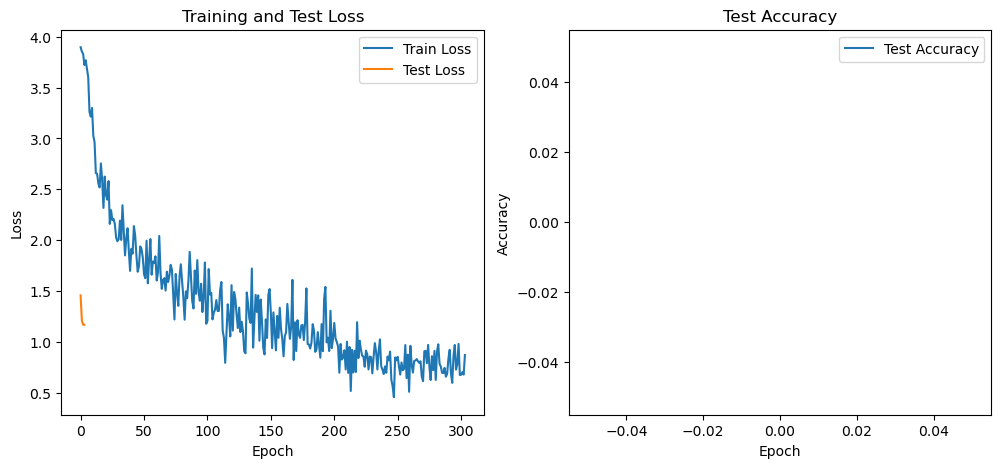

In [8]:
# Plot training results
def plot_results(logs):
    train_loss = [log['loss'] for log in logs if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
    eval_acc = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(eval_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(eval_acc, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Test Accuracy')
    
    plt.show()

plot_results(trainer.state.log_history)

In [14]:
model.save_pretrained("roberta_service_finetuned")
tokenizer.save_pretrained("roberta_service_finetuned")

('roberta_service_finetuned\\tokenizer_config.json',
 'roberta_service_finetuned\\special_tokens_map.json',
 'roberta_service_finetuned\\vocab.json',
 'roberta_service_finetuned\\merges.txt',
 'roberta_service_finetuned\\added_tokens.json')

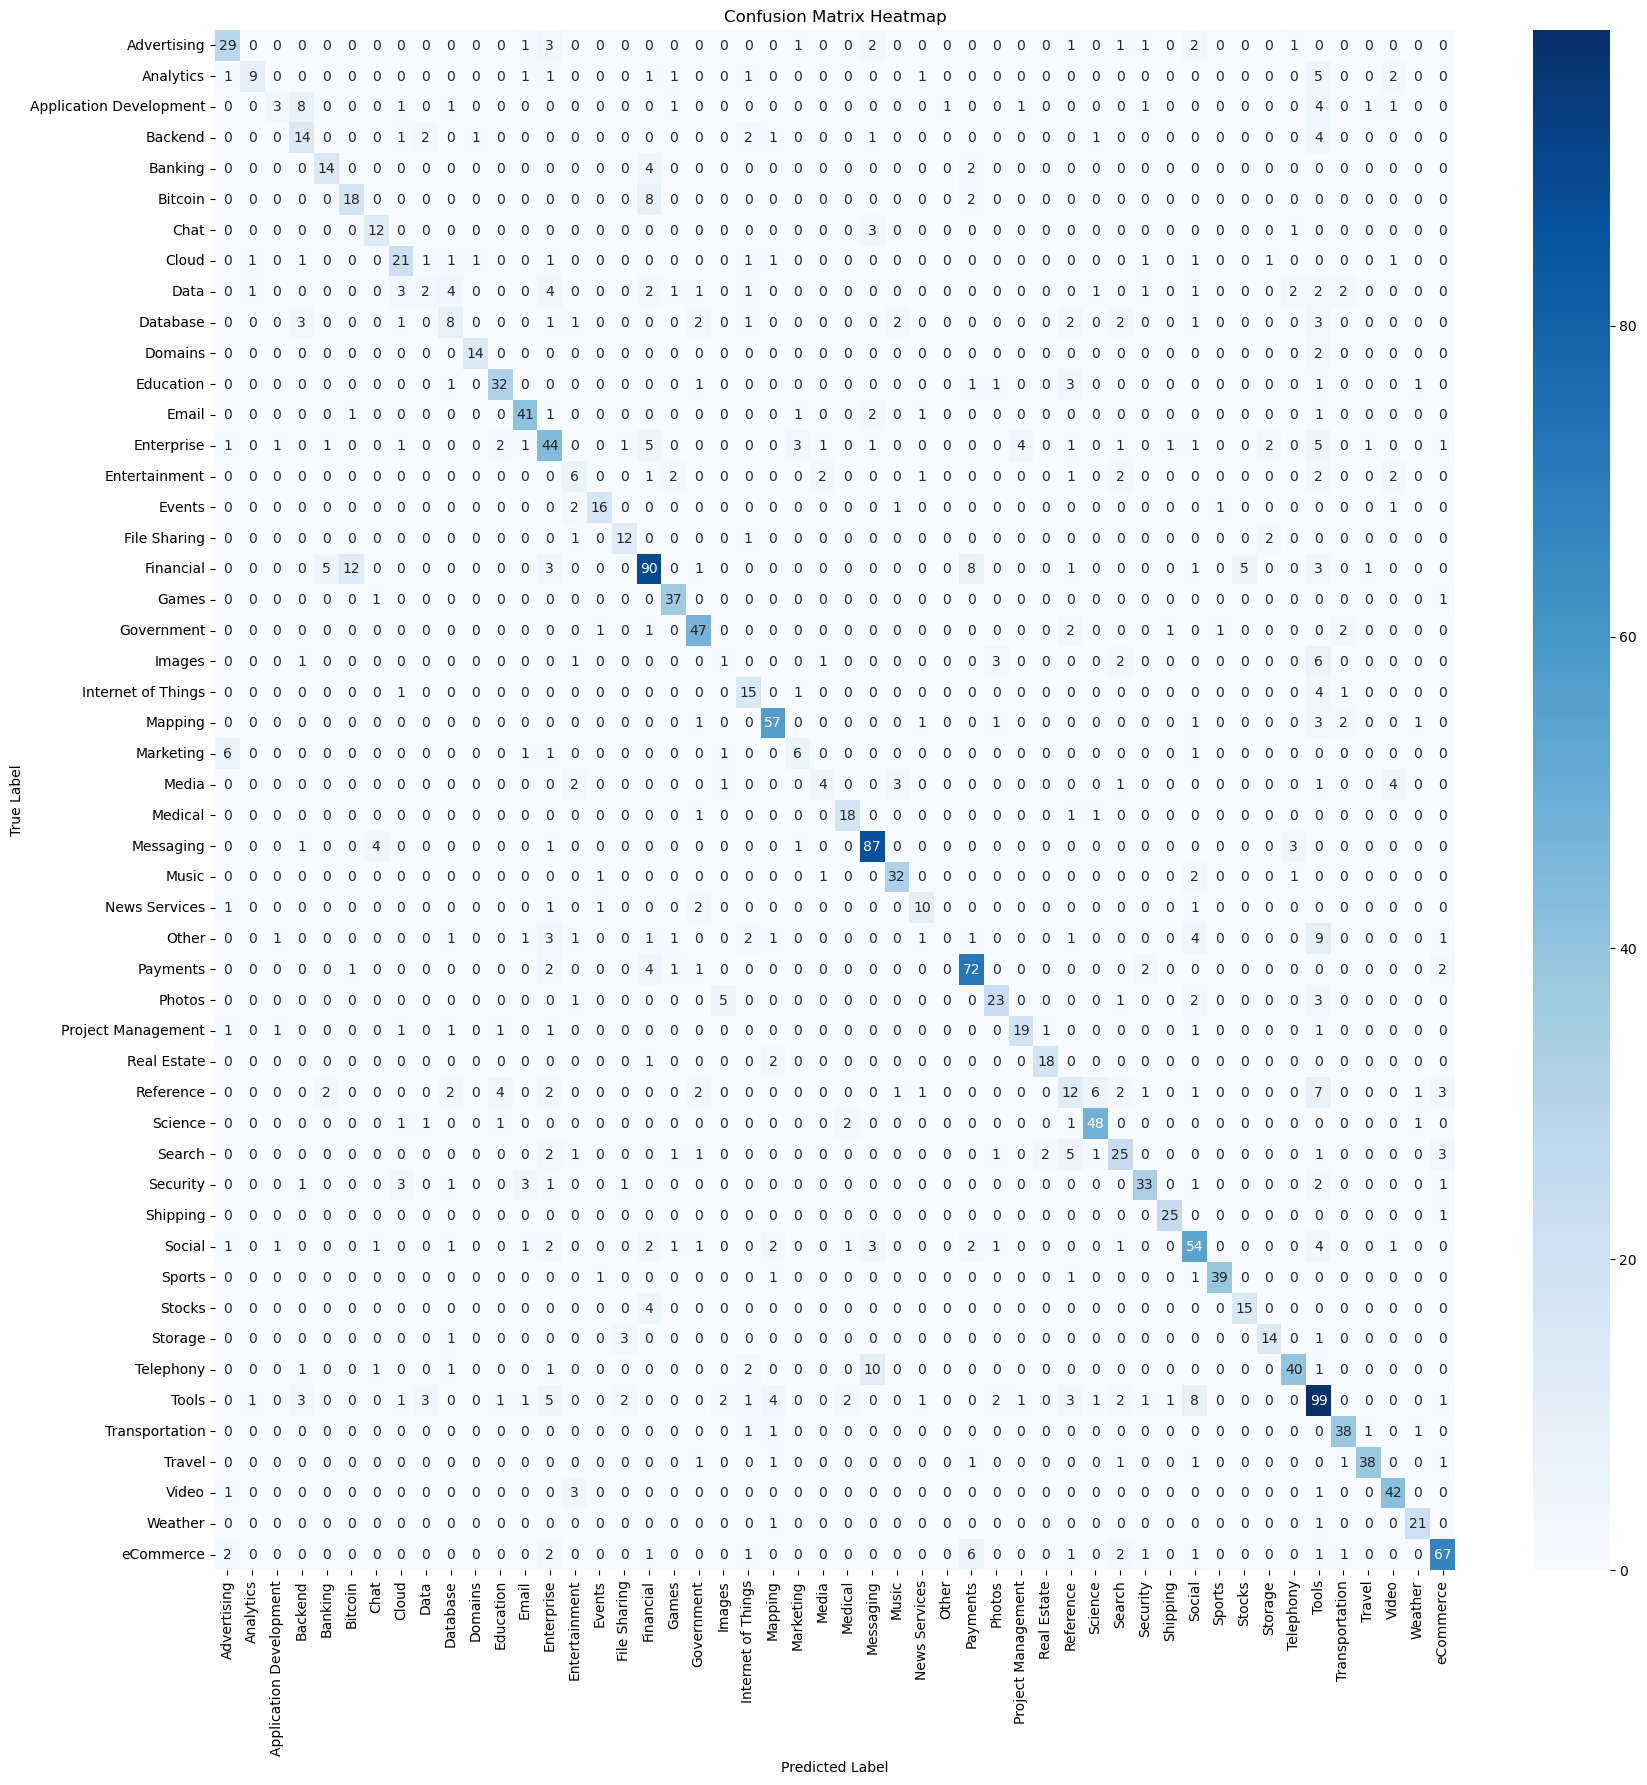

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(list(TestServices['Service Classification']), pred_labels)

# Plot confusion matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")

# Show plot
plt.show()


In [15]:
# Compute confusion matrix
cm = confusion_matrix(list(TestServices['Service Classification']), pred_labels)

# Compute accuracy per class
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Print accuracy for each category
for label, acc in zip(label_encoder.classes_, class_accuracy):
    print(f"Accuracy for class '{label}': {acc:.2%}")

Accuracy for class 'Advertising': 69.05%
Accuracy for class 'Analytics': 39.13%
Accuracy for class 'Application Development': 13.04%
Accuracy for class 'Backend': 51.85%
Accuracy for class 'Banking': 70.00%
Accuracy for class 'Bitcoin': 64.29%
Accuracy for class 'Chat': 75.00%
Accuracy for class 'Cloud': 63.64%
Accuracy for class 'Data': 7.14%
Accuracy for class 'Database': 29.63%
Accuracy for class 'Domains': 87.50%
Accuracy for class 'Education': 78.05%
Accuracy for class 'Email': 85.42%
Accuracy for class 'Enterprise': 55.70%
Accuracy for class 'Entertainment': 31.58%
Accuracy for class 'Events': 76.19%
Accuracy for class 'File Sharing': 75.00%
Accuracy for class 'Financial': 69.23%
Accuracy for class 'Games': 94.87%
Accuracy for class 'Government': 85.45%
Accuracy for class 'Images': 6.67%
Accuracy for class 'Internet of Things': 68.18%
Accuracy for class 'Mapping': 85.07%
Accuracy for class 'Marketing': 37.50%
Accuracy for class 'Media': 25.00%
Accuracy for class 'Medical': 85.71%